<a href="https://colab.research.google.com/github/jonkrohn/ML-foundations/blob/master/notebooks/learning-rate-scheduling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Rate Scheduling

This notebook improves upon the [*SGD from Scratch* notebook](https://github.com/jonkrohn/ML-foundations/blob/master/notebooks/SGD-from-scratch.ipynb) by: 

1. Using efficient PyTorch `DataLoader()` iterable to batch data for SGD
2. Scheduling a variable learning rate

In [1]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

### Simulate data

In [2]:
_ = torch.manual_seed(42)

In [3]:
n = 8000000

In [4]:
x = torch.linspace(0., 8., n)

$$y = mx + b + \epsilon = -0.5x + 2 + \mathcal{N}(0, 1)$$

In [5]:
y = (-0.5 * x) + 2 + torch.normal(mean=torch.zeros(n), std=1)

Randomly sample 2000 data points for model validation: 

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.00025, random_state=42)

In [8]:
x_valid.shape

torch.Size([2000])

In [9]:
x_train.shape

torch.Size([7998000])

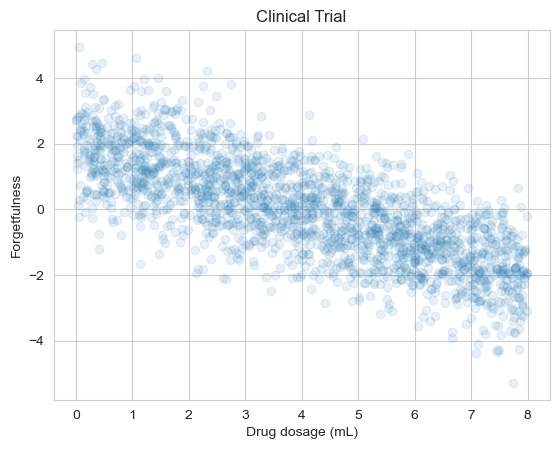

In [10]:
fig, ax = plt.subplots()
plt.title("Clinical Trial")
plt.xlabel("Drug dosage (mL)")
plt.ylabel("Forgetfulness")
_ = ax.scatter(x_valid, y_valid, alpha=0.1)

### Define model and "randomly" initialize model parameters

In [11]:
def regression(my_x, my_m, my_b):
    return (my_m * my_x) + my_b

In [12]:
m = torch.tensor([0.9]).requires_grad_()
b = torch.tensor([0.1]).requires_grad_()

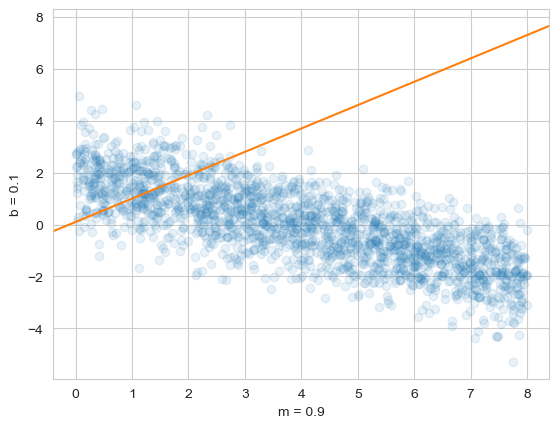

In [13]:
fig, ax = plt.subplots()

ax.scatter(x_valid, y_valid, alpha=0.1)

x_min, x_max = ax.get_xlim()
y_min = regression(x_min, m, b).detach().item()
y_max = regression(x_max, m, b).detach().item()

plt.ylabel('b = {}'.format('%.3g' % b.item()))
plt.xlabel('m = {}'.format('%.3g' % m.item()))

ax.set_xlim([x_min, x_max])
_ = ax.plot([x_min, x_max], [y_min, y_max], c='C01')

### Optimize parameters via SGD

In [14]:
from torch.utils.data import TensorDataset, DataLoader

In [15]:
train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=32) # set shuffle=True if multiple epochs

In [16]:
x_batch, y_batch = next(iter(train_loader))

In [17]:
x_batch

tensor([7.9039, 2.5032, 2.1550, 6.1589, 7.1057, 6.6262, 6.6151, 7.5177, 6.4350,
        7.8031, 4.0389, 4.0771, 4.0771, 2.3573, 7.5437, 1.2994, 4.7333, 1.6890,
        1.4867, 1.0857, 7.9499, 7.7148, 4.1468, 4.9756, 7.8536, 3.7126, 2.7072,
        7.5391, 2.3218, 1.7388, 1.8237, 6.2415])

In [18]:
y_batch

tensor([-1.1923,  0.5152,  0.7512, -0.7778, -1.4118,  0.0496, -1.4554, -0.7491,
        -1.6638, -1.3719,  0.5347, -0.0260,  0.3292,  0.1032, -2.0465,  2.4188,
        -0.9180, -0.6667,  1.7137,  3.2658, -0.7733, -1.8584, -0.0086, -0.5010,
        -2.3102,  1.4706,  0.9627, -3.8245,  2.5656,  1.8036,  0.6060, -1.4121])

**Step 1**: Forward pass

In [19]:
yhat = regression(x_batch, m, b)
yhat

tensor([7.2135, 2.3529, 2.0395, 5.6431, 6.4952, 6.0636, 6.0536, 6.8659, 5.8915,
        7.1228, 3.7350, 3.7694, 3.7694, 2.2216, 6.8893, 1.2695, 4.3600, 1.6201,
        1.4380, 1.0771, 7.2549, 7.0433, 3.8321, 4.5781, 7.1682, 3.4414, 2.5365,
        6.8851, 2.1896, 1.6649, 1.7414, 5.7174], grad_fn=<AddBackward0>)

**Step 2**: Compare $\hat{y}$ with true $y$ to calculate cost $C$

In [20]:
def mse(my_yhat, my_y): 
    sigma = torch.sum((my_yhat - my_y)**2)

    return sigma / len(my_y)

In [21]:
C = mse(yhat, y_batch)
C

tensor(33.3355, grad_fn=<DivBackward0>)

In [22]:
def labeled_regression_plot(my_x, my_y, my_m, my_b, my_C, include_grad=True):
    title = 'Cost = {}'.format('%.3g' % my_C.item())
    if include_grad:
        xlabel = 'm = {}, m grad = {}'.format('%.3g' % my_m.item(), '%.3g' % my_m.grad.item())
        ylabel = 'b = {}, b grad = {}'.format('%.3g' % my_b.item(), '%.3g' % my_b.grad.item())
    else:
        xlabel = 'm = {}'.format('%.3g' % my_m.item())        
        ylabel = 'b = {}'.format('%.3g' % my_b.item())
    
    fig, ax = plt.subplots()
    
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)

    ax.scatter(my_x, my_y)
    
    x_min, x_max = ax.get_xlim()
    y_min = regression(x_min, my_m, my_b).detach().item()
    y_max = regression(x_max, my_m, my_b).detach().item()

    ax.set_xlim([x_min, x_max])
    _ = ax.plot([x_min, x_max], [y_min, y_max], c='C01')

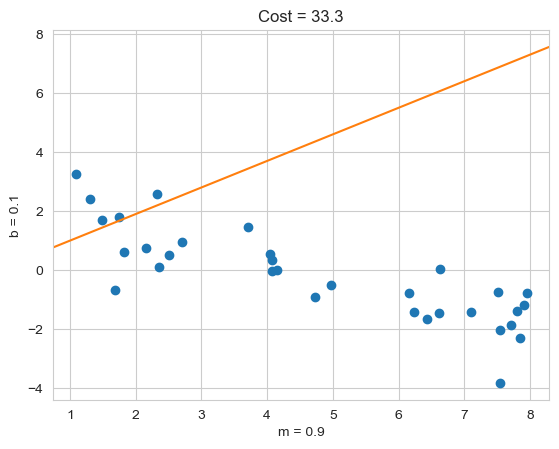

In [23]:
labeled_regression_plot(x_batch, y_batch, m, b, C, include_grad=False)

**Step 3**: Use autodiff to calculate gradient of $C$ w.r.t. parameters

In [24]:
C.backward()

In [25]:
gradient = torch.tensor([[b.grad.item(), m.grad.item()]]).T
gradient

tensor([[ 9.1138],
        [59.7826]])

In [26]:
theta = torch.tensor([[b, m]]).T 
theta

tensor([[0.1000],
        [0.9000]])

**Step 4**: Gradient descent $$ \boldsymbol{\theta}' = \boldsymbol{\theta} - \alpha \nabla C $$

In [27]:
lr = 0.02 # Doubled

In [28]:
new_theta = theta - (lr * gradient)
new_theta

tensor([[-0.0823],
        [-0.2957]])

Confirm $C$ is lower: 

In [29]:
b = new_theta[0]
m = new_theta[1]

In [30]:
C = mse(regression(x_batch, m, b), y_batch)
C

tensor(2.7568)

### Rinse and Repeat

In [31]:
b.requires_grad_()
_ = m.requires_grad_() 

Set $\lambda$ hyperparameter for learning rate decay:

In [32]:
lambd = 0.995 # 'lambda' is a Python reserved term

In [33]:
lr = lambd * lr
lr

0.0199

In [34]:
rounds = 1000 
for r in range(rounds): 
    x_batch, y_batch = next(iter(train_loader)) # Efficient batching
    
    yhat = regression(x_batch, m, b) # Step 1
    C = mse(yhat, y_batch) # Step 2
    
    C.backward() # Step 3
    
    if r % 50 == 0:
        print('Step {}, cost {}, m grad {}, b grad {}, lr {}'.format(r, '%.3g' % C.item(), '%.3g' % m.grad.item(), '%.3g' % b.grad.item(), '%.3g' % lr))
    
    gradient = torch.tensor([[b.grad.item(), m.grad.item()]]).T
    theta = torch.tensor([[b, m]]).T 
    
    new_theta = theta - (lr * gradient) # Step 4
    
    b = new_theta[0].requires_grad_()
    m = new_theta[1].requires_grad_()
    
    lr = lambd * lr # Decay learning rate

Step 0, cost 2.76, m grad -9.63, b grad -2.6, lr 0.0199
Step 50, cost 1.32, m grad 0.113, b grad -0.67, lr 0.0155
Step 100, cost 1.07, m grad 0.0862, b grad -0.51, lr 0.0121
Step 150, cost 0.956, m grad 0.0698, b grad -0.413, lr 0.00938
Step 200, cost 0.893, m grad 0.0592, b grad -0.35, lr 0.0073
Step 250, cost 0.857, m grad 0.052, b grad -0.308, lr 0.00568
Step 300, cost 0.835, m grad 0.0471, b grad -0.279, lr 0.00442
Step 350, cost 0.821, m grad 0.0436, b grad -0.258, lr 0.00344
Step 400, cost 0.811, m grad 0.041, b grad -0.243, lr 0.00268
Step 450, cost 0.804, m grad 0.0391, b grad -0.232, lr 0.00209
Step 500, cost 0.799, m grad 0.0377, b grad -0.223, lr 0.00162
Step 550, cost 0.795, m grad 0.0367, b grad -0.217, lr 0.00126
Step 600, cost 0.793, m grad 0.0359, b grad -0.212, lr 0.000983
Step 650, cost 0.791, m grad 0.0353, b grad -0.209, lr 0.000765
Step 700, cost 0.789, m grad 0.0348, b grad -0.206, lr 0.000596
Step 750, cost 0.788, m grad 0.0344, b grad -0.204, lr 0.000464
Step 80

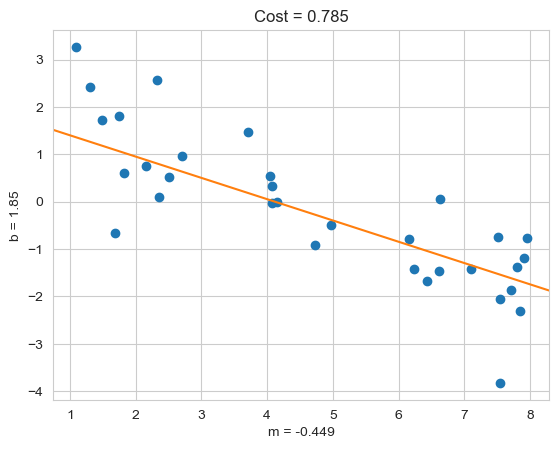

In [35]:
labeled_regression_plot(x_batch, y_batch, m, b, C, include_grad=False)

In [36]:
validation_cost = mse(regression(x_valid, m, b), y_valid)

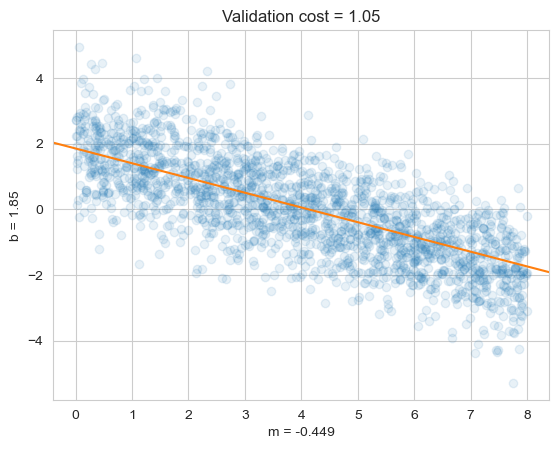

In [37]:
fig, ax = plt.subplots()

ax.scatter(x_valid, y_valid, alpha=0.1)

x_min, x_max = ax.get_xlim()
y_min = regression(x_min, m, b).detach().item()
y_max = regression(x_max, m, b).detach().item()

plt.title('Validation cost = {}'.format('%.3g' % validation_cost.item()))
plt.ylabel('b = {}'.format('%.3g' % b.item()))
plt.xlabel('m = {}'.format('%.3g' % m.item()))

ax.set_xlim([x_min, x_max])
_ = ax.plot([x_min, x_max], [y_min, y_max], c='C01')

Relative to the [*SGD from Scratch* notebook](https://github.com/jonkrohn/ML-foundations/blob/master/notebooks/SGD-from-scratch.ipynb): 

1. Carry out 1k SGD rounds in fraction of time it took to do 100
2. Lower validation cost due to more SGD rounds and (independently) learning rate scheduling

(Note that because of $\epsilon$ in the data simulation step, reaching zero cost on training data would only be possible with extreme overfitting and this would not correspond to improved fit on the validation data.)